<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/Taranov-Anatoly-folder/3_InspectClinicRSgr2_TA_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ТЕХНИЧЕСКОЕ ЗАДАНИЕ



Рекомендательная система для профпатолога (INSPECTRUM CLINIC)

Цель: Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.

Принцип работы: Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности. В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”. Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.

Требования интерфейсу: Минимальный уровень реализации: notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

Дополнительно: передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

Требования к тестированию, метрикам качества: Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%

# Загрузка библиотек и датасета

In [22]:
# Импорт библиотек и инструментов
from google.colab import files              # Импортируем библиотеку files для работы с файлами
import re                                   # Регулярные выражения
import pandas as pd                         # Импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt             # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import seaborn as sns                       # Импортируем модуль seaborn библиотеки matplotlib для построения графиков
import datetime                             # Импортируем модуль datetime для обработки данных в формете даты
import numpy as np                          # Импортируем библиотеку numpy

%matplotlib inline
import gdown
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [23]:
                                            # Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
data = pd.read_excel('/content/drive/MyDrive/БазыCSV/InClinic/ВесьЗаПериод.xlsx')       # Загрузка файла из диска в colab

# Анализ формы и состава данных

В ходе анализа предоставленной базы данных выяснилось что достаточно большая часть содержит информацию не влияющую на выполнение задачи по техническому заданию. Принято решение создания датафрейма на позициях необходимых для решения задачи.


---

**Запускать только при необходимости анализа**

In [ ]:
print(data.shape)                            # Форма и размер
print(data.size)                             # Колличество элементов
data.isna().sum().sum()                      # Вычислит общее количество пропусков во всей таблице
#data.info()                                 # Сводная информация
#data.head()                                 # Вывод первых 5 строк таблицы

(32686, 289)
9446254


8791393

In [ ]:
data.describe(include=['O'])                  # Статистика

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,Контрагент,Цех,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
count,32686,32686,32447,32682,32682,32686,32686,32686,32670,10596,...,6,6,6,6,864,22,22,22,94,6
unique,18318,16719,10265,3,3,468,2,2,610,750,...,1,1,1,1,1,1,1,1,9,2
top,b31f3c71-87d7-11ec-80fc-0cc47aab8067,a0a96ecb-6cd5-11ea-80dd-0cc47aab8067,1988-01-01T00:00:00,Мужской,Мужской,2023-05-31T00:00:00,Периодический,Периодический,14b3b113-2a96-11e9-80ce-0cc47aab8067,Без отдела,...,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,Z00.0,K86.1
freq,7,10,19,23122,23122,1755,32582,32582,2782,1964,...,6,6,6,6,864,22,22,22,42,4


In [ ]:
data.info([0,-1])                              # Анализ состава информации в столбцах

# Отбор столбцов с целевыми данными

* Отбор столбцов - персона/профессия/статус:
"КлиентДатаРождения",  "КлиентПол",  "ТипМедосмотраПредставление", "ПсихОсвидетельствование", "Профессия", "ЗаключениеМК", "ЗаключениеМКПредставление",  "ДиспансернаяГруппаПредставление",
"ВредныеФакторы".

* Отбор столбцов по специализациям врачей
 с целевой информацией - Специализация/обследование/состояние:
"МКБ101",  "МКБ102", "МКБ103",  "МКБ104", " Представление", "ДиагнозПредставление",   "Диагноз_ЗначениеПредставление",
"ПрофнепригодностьВременнаяПредставление",  "ПрофнепригодностьВременнаяПредставление1", "ПрофнепригодностьВременная1","Анамнез_ЗначениеПредставление",  "Профессиональное1", "ЖалобыДополнение", "Рекомендация1", "Заключение".


In [39]:
# Создание копии таблицы
df = data.copy()

In [40]:
# Список столбцов с персональными данными
person = ['КлиентДатаРождения', 'КлиентПол', 'Профессия','ВредныеФакторы',
          'ПсихОсвидетельствование', 'ЗаключениеМК', 'ЗаключениеМКПредставление']
def person_columns(df):
    person = []
    for column in df.columns:
                columns_selected.append(df[column])
    return df[person]

person_dat = df[person]

In [41]:
words = {"МКБ101", "МКБ102","МКБ103", "МКБ104",  "Представление",
         "ПрофнепригодностьВременнаяПредставление","ПрофнепригодностьВременнаяПредставление1",
         "ПрофнепригодностьВременная1","ЖалобыДополнение","Заключение"}
def find_columns(df, words):
    '''Функция для поиска столбцов в датафрейме df.Возвращаем:
     -новый датафрейм, состоящий только из целевых столбцов
    '''
    #разделяем названия столбцов на отдельные слова
    column_words = [s.split('_') for s in df.columns]
    # ищем вхождения каждого слова из списка words
    # в каждом списке слов из column_words
    word_indices = {}
    for i, cw in enumerate(column_words):
        for word in words:
            if word in cw:
                if i not in word_indices:
                    word_indices[i] = 1
                else:
                    word_indices[i] += 1

    #составляем список индексов столбцов, которые содержат
    #хотя бы одно искомое слово
    index_list = [i for i, count in word_indices.items() if count > 0]

    #возвращаем новый датафрейм, состоящий только из найденных столбцов
    return df.iloc[:, index_list]

diagnosis_dat = find_columns(df, words)


In [42]:
# Объединяяем выборки столбцов
result = pd.concat([person_dat, diagnosis_dat], axis=1)
df1= result

In [43]:
# Удаляем полностью пустые столбцы
df1.dropna(axis=1, how='all', inplace=True)
# Удаляем дубликаты столбцов
df1 = df1.loc[:,~df1.columns.duplicated()]
# Удаляем полностью пустые строки
df1.dropna(axis=0, how='all', inplace=True)
# Доля пропусков от общего количества элементов
df1.head(2).isna().sum() / df1.head(2).shape[0]
# Вычислим общее количество пропусков во всей таблице
df1.head(2).isna().sum().sum()
proc = df1.head(2).isna().sum().sum() / df1.head(2).size
# Вычислим общее количество пропусков в процентах во всей таблице
print('{:.1%}'.format(proc))

93.3%


In [44]:
# Замена всех пропусков на слово "Нет данных"
df1.fillna("Нет данных", inplace=True)
# Форма и размер
print(df1.shape)
# Колличество элементов
print(df1.size)
df1.head(1)

(32686, 194)
6341084


,КлиентДатаРождения,КлиентПол,Профессия,ВредныеФакторы,ПсихОсвидетельствование,ЗаключениеМК,ЗаключениеМКПредставление,Заключение,Гинекология1_МКБ101,Гинекология1_МКБ102,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,1989-12-31T00:00:00,Женский,Продавец-кассир,Нет данных,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных


In [45]:
df1.to_csv('/content/drive/MyDrive/БазыCSV/InClinic/df1.csv', index = False)

# Классификация условий труда

---
описание




Согласно действующему законодательству, вся трудовая деятельность условно
подразделяется на 4 категории, каждая из которых основывается на степени факторов риска для здоровья и жизни:

---

* Оптимальный — на территории и во внутренних помещениях сохраняется и
поддерживается здоровый микроклимат, положительно влияющий на производительность труда;

* Допустимый — сохраняются нормальные условия, уровень вредных факторов не превышает допустимых норм;

* Вредный — превышаются допустимые нормы, что причиняет вред здоровью человека;

* Опасный — условия труда способны повлечь причинение тяжкого вреда здоровью, иногда несут угрозу жизни.

---

В свою очередь, вредные и опасные производства подразделяются между собой на 4 степени тяжести:

1 Изменения, начавшиеся в организме человека, носят обратимый характер и обычно проявляются после завершения трудовой деятельности. Такие недуги на медицинском сленге называются «профессиональными заболеваниями»;

2 Патологические изменения проявляются более выражено и часто приводят к временной потере трудоспособности (человек регулярно уходит на больничный). Здесь наиболее часто развиваются хронические недуги, вызванные профессиональной деятельностью;

3 В организме протекают необратимые процессы, способные повлечь частичную потерю трудоспособности;

4 Происходят тяжелые функциональные расстройства внутренних органов и систем, что в запущенных случаях приводит к присвоению нерабочей группы инвалидности.


---


К сожалению "СОУТ"(специальная оценка условий труда) пока не располагает системой привязки категории рисков к группам профессии, к примеру ISCO-08, или иные подобные классификаторы.
 Единых методических указаний по управлению профессиональными
рисками пока не существует. Одна из причин - огромное разнообразие профессий и рисков. В одну только Систему стандартов безопасности труда (ССБТ) по состоянию на 2020 год
входит около 400 документов.

---

ISCO-08 МСКЗ-08 делит рабочие места на 10 основных групп:

Основные группы
* 1 Руководители
* 2 Специалисты-профессионалы
* 3 Специалисты-техники и иной средний специальный персонал
* 4 Служащие, занятые подготовкой и оформлением документации, учетом и
  обслуживанием
* 5 Работники сферы обслуживания и торговли
* 6 Квалифицированные работники сельского и лесного хозяйств, рыбоводства и
рыболовства
* 7 Квалифицированные рабочие промышленности и рабочие родственных занятий
* 8 Операторы и сборщики промышленных установок и машин
* 9 Неквалифицированные работники
* 0 Военнослужащие





 Основные группы и подгруппы

* 1 Руководители
11 Руководители высшего звена, высшие должностные лица и законодатели
12 Корпоративные управляющие
13 Руководители подразделений в сфере производства и специализированных
сервисных услуг
14 Руководители в сфере гостиничного бизнеса, руководители (управляющие) в
магазинах и родственных областях деятельности

* 2 Специалисты-профессионалы
21 Специалисты-профессионалы в области науки и техники
22 Специалисты-профессионалы в области здравоохранения
23 Специалисты-профессионалы в области образования
24 Специалисты-профессионалы в сфере бизнеса и администрирования
25 Специалисты-профессионалы по информационно-коммуникационным
технологиям (ИКТ)
26 Специалисты-профессионалы в области права, гуманитарных областей и
культуры

* 3 Специалисты-техники и иной средний специальный персонал
31 Специалисты-техники в области науки и техники
32 Средний медицинский персонал здравоохранения
33 Средний специальный персонал по экономической и административной
деятельности
34 Средний специальный персонал в области юриспруденции, социальной
работы, культуры и родственных занятий
35 Специалисты-техники в области ИКТ

* 4 Служащие, занятые подготовкой и оформлением документации, учетом и
обслуживанием
41 Служащие общего профиля и обслуживающие офисную технику
42 Служащие сферы обслуживания населения
43 Служащие в сфере обработки числовой информации и учета материальных
ценностей
44 Другие офисные служащие

* 5 Работники сферы обслуживания и торговли
51 Работники сфер индивидуальных услуг
52 Продавцы
53 Работники, оказывающие услуги по индивидуальному уходу
54 Работники служб, осуществляющих охрану граждан и собственности

* 6 Квалифицированные работники сельского и лесного хозяйств, рыбоводства и
рыболовства
61 Квалифицированные работники сельского хозяйства, производящие товарную
продукцию
62 Товарные производители лесной и рыбной продукции и охотники
63 Квалифицированные работники сельского хозяйства, рыболовства, охотники и
сборщики урожая, производящие продукцию для личного потребления

* 7 Квалифицированные рабочие промышленности и рабочие родственных занятий
71 Рабочие, занятые в строительстве, и рабочие родственных занятий
72 Рабочие металлообрабатывающей промышленности, машиностроения и
родственных занятий
73 Высококвалифицированные рабочие ручного труда и полиграфического
производства
74 Рабочие в области электротехники и электроники
75 Рабочие пищевой, деревообрабатывающей, текстильной и швейной
промышленности и рабочие родственных занятий

* 8 Операторы и сборщики промышленных установок и машин
81 Операторы промышленных установок и стационарного оборудования
82 Сборщики
83 Водители и операторы подвижного оборудования

* 9 Неквалифицированные работники
91 Прислуга и уборщики
92 Неквалифицированные рабочие сельского и лесного хозяйств, рыбоводства и
рыболовства
93 Неквалифицированные рабочие, занятые в горнодобывающей
промышленности, строительстве, обрабатывающей промышленности и на транспорте
94 Помощники в приготовлении пищи
95 Уличные торговцы и другие неквалифицированные работники, оказывающие
различные уличные услуги
96 Неквалифицированные работники по сбору мусора и другие
неквалифицированные работники

* 0 Военнослужащие
01 Офицеры в действующей армии
02 Военнослужащие неофицерских званий
03 Военнослужащие других званий


# Анализ данных в отобранных столбцах, отбраковка.

По результату анализа данных в отобранных столбцах остаются только столбцы содержащие условно-полноценную информацию небходимую для обучения "НС"

Клиент
- КлиентДатаРождения,  КлиентПол,  Профессия,  ВредныеФакторы.

Обследование
- ПсихОсвидетельствование,  ЗаключениеМК,  ЗаключениеМКПредставление,  МКБ101,  МКБ102,  МКБ103,  МКБ104,  Представление,  ПрофнепригодностьВременнаяПредставление,
 ПрофнепригодностьВременнаяПредставление1, ПрофнепригодностьВременная1, ЖалобыДополнение, Заключение.


---
К сожалению в новой версии датасета отсутствуют столбцы : "ПрофнепригодностьВременнаяПредставление","ПрофнепригодностьВременнаяПредставление1", "ПрофнепригодностьВременная1","ЖалобыДополнение", в 1 версии датасета в них была полезная информация для работы "НС".

**Запускать только при необходимости анализа**

Персона

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'КлиентПол' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['Женский', 'Нет данных', 'Мужской', 'НеУказан']


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'Профессия' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
unique_values

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'ВредныеФакторы' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
unique_values

Результаты обследования

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'ПсихОсвидетельствование' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
unique_values

[False, True]

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'ЗаключениеМК' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['ОграниченноГоден', 'тракторист', 'Годен к работе в указанных условиях', 'Годен к работе в указанных условиях (с коррекцией зрения)', ' п. 11.4', 'Годен к работе в указанных условиях (без работ на высотах)', 'ГоденСКоррекциейСлуха', 'Газоспасатель', 'Нет данных', 'ГоденСКоррекциейЗрения', 'Годен к работе в указанных условиях (с коррекцией слуха)', 'Ограниченно годен', ' п. 11.3', 'Годен', 'Нуждается в дообследовании и лечении', 'НуждаетсяВДообследованииИЛечении', 'машинист бульдозера', 'Не годен', 'Негоден', 'ГоденБезРаботНаВысотах', ' Газоспасатель']


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'ЗаключениеМКПредставление' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['Годен', 'Не годен', 'Нет данных', 'тракторист', 'Годен к работе в указанных условиях', 'ГоденСКоррекциейЗрения', 'Годен к работе в указанных условиях (с коррекцией зрения)', 'Годен к работе в указанных условиях (с коррекцией слуха)', 'Нуждается в дообследовании и лечении', ' п. 11.4', 'Ограниченно годен', 'Годен к работе в указанных условиях (без работ на высотах)']


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "Представление" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
unique_values

['Годен',
 'Не годен',
 'Нет данных',
 'тракторист',
 'Годен к работе в указанных условиях',
 'ГоденСКоррекциейЗрения',
 'Годен к работе в указанных условиях (с коррекцией зрения)',
 'Годен к работе в указанных условиях (с коррекцией слуха)',
 'Нуждается в дообследовании и лечении',
 ' п. 11.4',
 'Ограниченно годен',
 'Годен к работе в указанных условиях (без работ на высотах)']

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "МКБ101" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['D13.0', 'N88.4', 'F06.6', 'L30.9', 'D22.1', 'H11.1', 'Z00.4', 'L40.9', 'E66.0', 'T90.0', 'K29.4', 'D13.4', 'K40.9', 'H18.9', 'H91.9', 'I25.9', 'K20', 'I45.6', 'F10.3', 'O00.0', 'H55', 'N73.9', 'I49.9', 'B35.2', 'E10.8', 'K31.7', 'Z76.9', 'H80.1', 'K76.9', 'H17.9', 'H10.5', 'H65.3', 'S54.0', 'J00', 'N11.9', 'Q44.6', 'N76.1', 'N72', 'H28.2', 'N81.9', 'I47.9', 'D25.9', 'K29.9', 'I69.3', 'G96.9', 'H53.5', 'H10.1', 'K29.7', 'K81.8', 'I48', 'J38.2', 'J38.0', 'Н27', 'K80.1', 'H35.3', 'M05.9', 'H49.9', 'N28.1', 'K82.9', 'E04.1', 'I20.9', 'I67.8', 'Z00.5', 'I48.9', 'B37.8', 'N87.9', 'N85', 'K82.8', 'J35.8', 'K86.0', 'N95.2', 'F10.7', 'D25', 'F06.7', 'I48.0', 'K40.2', 'H16.9', 'H11.9', 'H74.1', 'K00.0', 'K29.3', 'N85.9', 'N60.2', 'T92.4', 'H74.8', 'H40.0', 'M51.1', 'N30.2', 'J45.0', 'T95.8', 'R00.1', 'M17.9', 'H72.9', 'L80.XX', 'Q25.6', 'E03.9', 'I49.8', 'N95.1', 'I12.9', 'F92.9', 'R25.1', 'J31.0', 'H17.8', 'T90.9', 'S02.01', 'H51.9', 'K02.0', 'J34.2', 'J30.2', 'H47.2', 'J37.0', 'F41.0', 'K64.

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "МКБ102" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['C50.1', 'K80.5', 'N83.2', 'H26.9', 'K29.7', 'L23.5', 'K29.6', 'H55', 'H52.2', 'H54.4', 'Q21.1', 'I70.0', 'T90.4', 'F06.8', 'H66.1', 'D35.2', 'D25.0', 'I45.8', 'K82.9', 'H02.4', 'K81.1', 'H90.3', 'E80.4', 'K91.5', 'D25', 'E11.9', 'I49.8', 'H25.0', 'K02.0', 'I05.9', 'J45.8', 'G93.4', 'N30.9', 'G90.8', 'K05.4', 'I77.9', 'K02.1', 'H90.4', 'H25', 'C81.9', 'E11', 'Нет данных', 'H47.2', 'Q13.0', '4.4,5.1,6.1', 'T94.0', 'K29.5', 'I83.9', 'H26.1', 'K29.9', 'M86.6', 'N80.0', 'H52.4', 'C53.9', 'H91.1', 'K76.6', 'I25.8', 'K05.3', 'E11.8', 'J45.9', 'I49.9', 'K86.1', 'H53.0', 'I67.9', 'I34.9', 'J45.0', 'D25.9', 'K80.2', 'F06.6', 'J44.9', 'D16.0', 'F10.3', 'I11.9', 'K25.7', 'C50.4', 'N84.1', 'H74.1', 'Q12.0', 'J42', 'H52.1', 'K29.3', 'M17.9', 'K50.9', 'I72.1', 'F10.2', 'N20.9', 'K44.9', 'N60.0', 'R73.9', 'N11.9', 'H50.0', 'H50.1', 'K04.5', 'I25.0', 'H52.3', 'N30.2', 'L28.0', 'D50.9', 'M42.1', 'K00.0', 'E66.0', 'H17.1', 'C03.0', 'I25.2', 'N28.1', 'H53.9', 'H50.9', 'J33.0', 'I25.9', 'H40.1', 'H34.8',

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "МКБ103" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['I25.8', 'K29.8', 'K76.0', 'K29.6', 'K29.3', 'M05.9', 'M15.9', 'K05.3', 'I06.8', 'N60.2', 'N83.2', 'I25.2', 'Нет данных', 'K80.2', 'K50.9', 'K26.7', 'I67.8', 'H53.0', 'N30.2', 'H66.1', 'K86.1', 'Z00.0', 'H90.3', 'H52.2', 'H52.1', 'D25', 'K81.8', 'H55', 'I11.9', 'H52.0', 'J45.8', 'N30.9', 'K29.5', 'R73.9']


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "МКБ104" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

['I25.8', 'K29.6', 'I70.0', 'I06.8', 'N60.2', 'I25.2', 'Нет данных', 'K80.2', 'H53.0', 'K86.1', 'Z00.0', 'H90.3', 'H52.2', 'L20.9', 'I25.9', 'H52.1', 'I11.9', 'H52.0', 'K29.5', 'R73.9']


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "ПрофнепригодностьВременнаяПредставление" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

[]


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "ПрофнепригодностьВременнаяПредставление1" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)

[]


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "ПрофнепригодностьВременная1" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
print(unique_values)



[]


In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if "ЖалобыДополнение" in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
unique_values

[]

In [ ]:
# Уникальные значения колонки
unique_values = []
for column in df1.columns:
    if 'Заключение' in column:
        unique_values.extend(df1[column].unique())
unique_values = list(set(unique_values))
unique_values

# Корректировка колонки'Профессия'

План:

Сделать выборку в колонке 'Профессия' по основному показателю профессии.

Привести список профессий в колонке 'Профессия' к форме применимой для классификации и группировке по типу  МСКЗ-08

Разделение на группировки (Военных не берём в расчёт ) на 9 классов позволит нейронной сети более точно определить соответствующую кореляцию каждой группе и далее кластеризовать требования по наличию потологий для определённой профессии.

Так же можно создать списки категорий профессий по должностям с разделением на степени факторов риска.

Степени факторов риска: Оптимальный,  Допустимый,  Вредный,  Опасный.

Присвоить категории профессии индекс факторов риска, создать новую колонку 'класс безопасности' и заполнить соответствующими значениями индексов.

Эти мероприятия позволят более точно привязать конкретную профессию и её вредные факторы к персоне со своими факторами - возраст, пол, и наличие патологий и других негативных моментов здоровья.

Всё это позволит определить: подходит ли человек однозначно для выполнения обязанностей или есть необходимость для тщательного выяснения где причина несоответствия и насколько это недопустимо.

**В этом и будет заключатся РЕКОМЕНДАЦИЯ**.


---


РАБОТА С КОЛОНКОЙ "Профессия" НЕ ЗАКОНЧЕНА НЕ ЗАПУСКАТЬ

## Работа над колонкой
Для структурирования данных о профессии и в дальнейшем для классификации и группировке по типу МСКЗ-08 была сделанна выборка всех профессий присутствующих в датасете. Из 32686 записей о профессии клиентов выбранно 624 названия профессии. Для структурирования по намеченному плану необходимо произвести работу по зачистке и исправлению написаний названия тех же профессий но с иным написанием  названия.Присвоение индекса группы по МСКЗ-08.

Пока на этом работа приостановленна. Нет ресурса времени для приведения кучи мусора к полноценно структурированным данным.  

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/БазыCSV/InClinic/df1.csv')

In [ ]:
df_p = pd.read_excel('/content/drive/MyDrive/БазыCSV/InClinic/Проф1.xlsx')

In [ ]:
df_p.head(10)

,Проф
0,cip мойки
1,cанитарка
2,cлесарь механосборочных работ
3,cу шеф
4,авиамеханик
5,авиатехник
6,авиатехник аирэо
7,автомат. и полуавт. линий
8,автомойщик
9,автослесарь


In [ ]:
# Создание копии таблицы
df2 =df1.copy()

In [ ]:
df2["Профессия"] = df2["Профессия"].str.lower()  # приведение значений к нижнему регистру
#df2 = df2.sort_values("Профессия")  # сортировка по алфавиту

df2.head(3)  # вывод первых 5 строк таблицы


,КлиентДатаРождения,КлиентПол,Профессия,ВредныеФакторы,ПсихОсвидетельствование,ЗаключениеМК,ЗаключениеМКПредставление,Заключение,Гинекология1_МКБ101,Гинекология1_МКБ102,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,1989-12-31T00:00:00,Женский,продавец-кассир,Нет данных,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
1,1998-07-20T00:00:00,Женский,продавец-кассир,2023-10-04 00:00:00,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
2,2002-01-04T00:00:00,Женский,младший продавец-консультант,23,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных


In [ ]:
#dfp = df2[['Профессия']]
# Сохраним колонку 'Профессия' и поработаем в excel
#df2.to_excel('/content/drive/MyDrive/БазыCSV/InClinic/df3.xlsx')

In [ ]:
df2['Назв.профессии'] = ''
def find_and_fill(df2, df_p):
    # разделяем названия столбцов на отдельные слова
    row_words = [s.split('_') for s in df2['Профессия']]

    # ищем вхождения каждого слова из списка words
    # в каждом списке слов из row_words
    word_indices = {}
    for i, cw in enumerate(row_words):
        for word in df_p['Проф']:
            if word in cw:
                if i not in word_indices:
                    word_indices[i] = [word]
                else:
                    word_indices[i].append(word)

    # создаем новый столбец 'Назв.профессии', содержащий все найденные слова
    df2['Назв.профессии'] = pd.Series(word_indices)

    return df2['Назв.профессии']

result = find_and_fill(df2, df_p)
result.head(5)

In [ ]:
df2['Назв.профессии'].head(50)

РАБОТА С КОЛОНКОЙ "Профессия" НЕ ЗАКОНЧЕНА

# Подготовка данных

In [1]:
# Импорт библиотек и инструментов
from google.colab import files              # Импортируем библиотеку files для работы с файлами
import pandas as pd                         # Импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt             # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import seaborn as sns                       # Импортируем модуль seaborn библиотеки matplotlib для построения графиков
import gdown
import numpy as np
import re
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [3]:
                                            # Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/БазыCSV/InClinic/df1.csv')

In [5]:
# Создание копии таблицы
df3 =df1.copy()

In [ ]:
df3.head(3)

,КлиентДатаРождения,КлиентПол,Профессия,ВредныеФакторы,ПсихОсвидетельствование,ЗаключениеМК,ЗаключениеМКПредставление,Заключение,Гинекология1_МКБ101,Гинекология1_МКБ102,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,1989,Женский,Продавец-кассир,Нет данных,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
1,1998,Женский,Продавец-кассир,2023-10-04 00:00:00,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
2,2002,Женский,Младший продавец-консультант,23,False,Годен,Годен к работе в указанных условиях,Годен к работе в указанных условиях,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных


# Корректировка и нормализация

Колонка возраст

In [6]:
# Из полной даты рождения нужен толко год возьмём его
df3['КлиентДатаРождения'] = df3['КлиентДатаРождения'].str[:4]

In [7]:

# Год превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  arg = int(arg)  # преобразуем строку в число
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))

getParameterAgeVect('1962')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [8]:
import numpy as np

def getParameterAgeVect(arg):
    arg = int(arg)  # преобразуем строку в число
    age_class = min(4, max(0, int((arg - 16) / 10)))
    age_vect = np.zeros(5, dtype=int)
    age_vect[age_class] = 1
    return age_vect
getParameterAgeVect('1962')

array([0, 0, 0, 0, 1])

Колонка пол

In [9]:
# Уникальные значения колонки
display(df3['КлиентПол'].unique())

array(['Женский', 'Мужской', 'Нет данных', 'НеУказан'], dtype=object)

In [10]:
# заменить 'НеУказан' на 'Нет данных' в столбце 'КлиентПол'
df3['КлиентПол'] = df3['КлиентПол'].replace('НеУказан', 'Нет данных')



In [11]:
def Sex_class(arg):
    # Создаем список с
    sex_c = [0,0,0]
    if 'М' in arg:
        sex_c = [1,0,0]
    if 'Ж' in arg:
        sex_c = [0,1,0]
    if 'Нет данных' in arg:
        sex_c = [0,0,1]
    # Возвращаем список
    return sex_c
# Проверяем функцию с аргументом 'м'
#sex_c = Sex_class('Ж')
# Выводим значение
#sex_c
Sex_class('М')

[1, 0, 0]

Колонка Профессия

Колонка Вредные Факторы

In [12]:
# Уникальные значения колонки
display(df3['ВредныеФакторы'].unique())

array(['Нет данных', '2023-10-04 00:00:00', '23', ...,
       '11.3,11.4,5.1,18.2', '4.4,5.1,6.1,15,17', '4.4,5.1,15,6.1,17'],
      dtype=object)

In [13]:
# поиск значений с помощью регулярных выражений и удаление найденных записей
df3 = df3[~df3['ВредныеФакторы'].str.match(r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}')]

In [14]:
# токенизация строк по запятой
df3['ВредныеФакторы'] = df3['ВредныеФакторы'].apply(lambda x: x.split(','))

# конвертация в матрицу Bag of Words
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(df3['ВредныеФакторы'].apply(lambda x: ', '.join(x)))
x_tr = X.toarray()

In [15]:
x_tr[50:56:2]


array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Колонка ПсихОсвидетельствование

In [16]:
# Уникальные значения колонки
display(df3['ПсихОсвидетельствование'].unique())

array([False,  True])

In [17]:
def PsExam_class(arg):
    # Создаем список с одним элементом 0
    PsExam = [0]
    # Если True, то значение 1 (по умолчанию 0 для False)
    if 'True' in arg:
        PsExam = 1
    # Возвращаем список
    return PsExam
# Проверяем функцию с аргументом 'False'
PsExam = PsExam_class('False')
# Выводим значение
PsExam

[0]

Колонка'ЗаключениеМК'

In [18]:
# Уникальные значения колонки
display(df3['ЗаключениеМК'].unique())

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', 'Нет данных',
       'ГоденБезРаботНаВысотах', 'ГоденСКоррекциейСлуха', ' п. 11.3',
       'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель',
       ' Газоспасатель', 'Негоден'], dtype=object)

In [62]:
index_list = df3[(df3['ЗаключениеМК'] == 'машинист бульдозера') |
                 (df3['ЗаключениеМК'] == ' Газоспасатель') |
                  (df3['ЗаключениеМК'] == 'Газоспасатель') |
                   (df3['ЗаключениеМК'] == ' п. 11.3') |
                    (df3['ЗаключениеМК'] == 'Нет данных')].index.tolist()


In [63]:
df3.drop(index_list, inplace=True)

In [64]:
class_list = ['Годен','НуждаетсяВДообследовании']
def health_sc(df3, column_name, class_list):
    for class_name in class_list:
        count = len(df3[df3[column_name] == class_name])
        print(f'Количество записей для класса {class_name}: {count}')
# количество записей по классам
health_sc(df3, 'ЗаключениеМК', class_list)

# Сокращение классов до 3
df3['ЗаключениеМК'].replace('ГоденСКоррекциейЗрения', 'НуждаетсяВДообследовании', inplace=True)
df3['ЗаключениеМК'].replace('ГоденСКоррекциейСлуха', 'НуждаетсяВДообследовании', inplace=True)
df3['ЗаключениеМК'].replace('ГоденБезРаботНаВысотах', 'НуждаетсяВДообследовании', inplace=True)
df3['ЗаключениеМК'].replace('НуждаетсяВДообследованииИЛечении', 'НуждаетсяВДообследовании' , inplace=True)
df3['ЗаключениеМК'].replace('ОграниченноГоден', 'НуждаетсяВДообследовании', inplace=True)
df3['ЗаключениеМК'].replace('Нет данных', 'НуждаетсяВДообследовании', inplace=True)
df3['ЗаключениеМК'].replace('Негоден', 'НуждаетсяВДообследовании', inplace=True)

# Удаление строк без заключения
mask = df3['ЗаключениеМК'].str.contains('|'.join(class_list)) > 0
condition = df3[mask]

# Функция для определения статуса здоровья
def health_stat(condition):
    out = [0, 0]
    if ('Годен' in condition):
        out[0]= 1
    if ('НуждаетсяВДообследовании' in condition):
        out[1]= 1

    # Присваиваем список 'out' переменной 'condition_ohe'
    condition_ohe = out
    return condition_ohe
# Пример вызова функции
health_stat('НуждаетсяВДообследовании')

Количество записей для класса Годен: 16614
Количество записей для класса НуждаетсяВДообследовании: 1051


[0, 1]

ЗаключениеМКПредставление

In [22]:
# Уникальные значения колонки
display(df3['ЗаключениеМКПредставление'].unique())

array(['Годен к работе в указанных условиях',
       'Годен к работе в указанных условиях (с коррекцией зрения)',
       'Нуждается в дообследовании и лечении',
       'Годен к работе в указанных условиях (без работ на высотах)',
       'Годен к работе в указанных условиях (с коррекцией слуха)',
       'Ограниченно годен', 'Не годен'], dtype=object)

In [23]:
index_list_2 = df3[(df3['ЗаключениеМКПредставление'] == 'тракторист') |
                   (df3['ЗаключениеМКПредставление'] == ' п. 11.4')].index.tolist()

In [24]:
df3.drop(index_list_2, inplace=True)

In [25]:
class_list = ['Годен',
              'с коррекцией зрения',
              'без работ на высотах',
              'с коррекцией слуха',
              'Ограниченно годен','Нуждается в дообследовании и лечении']
def health_sp(df3, column_name, class_list):
    for class_name in class_list:
        count = len(df3[df3[column_name] == class_name])
        print(f'Количество записей для класса {class_name}: {count}')
# количество записей по классам
health_sp(df3, 'ЗаключениеМКПредставление', class_list)

# Сокращение классов до 3
df3['ЗаключениеМКПредставление'].replace('Годен к работе в указанных условиях','Годен', inplace=True)
df3['ЗаключениеМКПредставление'].replace('Годен к работе в указанных условиях (с коррекцией зрения)', 'с коррекцией зрения', inplace=True)
df3['ЗаключениеМКПредставление'].replace('Годен к работе в указанных условиях (без работ на высотах)', 'без работ на высотах', inplace=True)
df3['ЗаключениеМКПредставление'].replace('Годен к работе в указанных условиях (с коррекцией слуха)', 'с коррекцией слуха', inplace=True)


# Удаление строк без заключения
mask = df3['ЗаключениеМКПредставление'].str.contains('|'.join(class_list)) > 0
condit = df3[mask]

# Функция для определения статуса здоровья
def health_stp(condit):
    out = [0, 0, 0, 0, 0, 0]
    if ('Годен' in condit):
        out[0]= 1
    if ('с коррекцией зрения' in condit):
        out[1]= 1
    if ('без работ на высотах' in condit):
        out[2]= 1
    if ('с коррекцией слуха' in condit):
        out[3]= 1
    if ('Ограниченно годен' in condit):
        out[4]= 1
    if ('Нуждается в дообследовании и лечении' in condit):
        out[5]= 1

    # Присваиваем список 'out' переменной 'condition_ohe'
    condit_ohe = out
    return condit_ohe
# Пример вызова функции
health_stp('без работ на высотах')

Количество записей для класса Годен: 0
Количество записей для класса с коррекцией зрения: 0
Количество записей для класса без работ на высотах: 0
Количество записей для класса с коррекцией слуха: 0
Количество записей для класса Ограниченно годен: 4
Количество записей для класса Нуждается в дообследовании и лечении: 38


[0, 0, 1, 0, 0, 0]

Заключение

In [26]:
# Уникальные значения колонки
display(df3['Заключение'].unique())

array(['Годен к работе в указанных условиях',
       'Годен к работе в указанных условиях (с коррекцией зрения)',
       'Годен к работе в указанных условиях (с коррекцией зрения) кроме п. 17',
       'Годен к работе в указанных условиях (с коррекцией зрения) кроме п.17.',
       'Нуждается в дообследовании и лечении',
       'Годен к работе в указанных условиях с коррекцией зрения (кроме п.17)',
       'Годен к работе в указанных условиях (с коррекцией зрения) кроме п.6.1',
       'Годен к работе в указанных условиях (без работ на высотах)',
       'Годен к работе в указанных условиях (с коррекцией зрения) кроме п.6.1,п.8.',
       'Годен к работе в указанных условиях (кроме п.17)',
       'Годен к работе в указанных условиях с коррекцией зрения (кроме п.6.1, п.14 и п.17)',
       'Годен к работе в указанных условиях (кроме п.14 и п.17)',
       'Годен к работе в указанных условиях (кроме п.4.4)',
       'Годен к работе в указанных условиях (с коррекцией зрения) кроме п.17',
       'Г

In [27]:
df3['Заключение'].replace('Годен к работе в указанных условиях','Годен', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях (с коррекцией зрения)', 'с коррекцией зрения', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях (без работ на высотах)', 'без работ на высотах', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях (с коррекцией слуха)', 'с коррекцией слуха', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях с коррекцией зрения', 'с коррекцией зрения', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях, с коррекцией зрения', 'с коррекцией зрения', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях, кроме   ', 'кроме', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях. Противопаказанаработа с подьемом и перемещением тяжестей - более 5 кг, длительной ходьбой, более 500 метров, работа на высоте,в холодных помещениях, эмоциональные нагрузки,полный рабочий день.','Ограниченно годен', inplace=True)
df3['Заключение'].replace('Годен к работе в указанных условиях (без работ на высотах) Противопоказана работа связанная с высотой ,подьем и перемещение тяжестей ,длительной ходьбой.', 'без работ на высотах', inplace=True)

In [28]:

# создадим новый DataFrame, где будут только строки, в которых больше 7 слов
df_filtered = df3[df3['Заключение'].str.split().apply(len) > 7]

# для строк, где больше 6 слов, возьмем только последние слова
df_filtered['Заключение'] = df_filtered['Заключение'].apply(lambda x: ' '.join(x.split(' ')[6:]))

# объединим отфильтрованные строки с исходным DataFrame
result_df = pd.concat([df_filtered, df3[df3['Заключение'].str.split().apply(len) <= 7]])

# выведем результат
result_df['Заключение'][3::]


<ipython-input-28-dbea8e824946>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Заключение'] = df_filtered['Заключение'].apply(lambda x: ' '.join(x.split(' ')[6:]))


931                   (с коррекцией зрения) кроме п.6.1
933                   (с коррекцией зрения) кроме п.6.1
1436             (с коррекцией зрения) кроме п.6.1,п.8.
1674                                       (кроме п.17)
2056     с коррекцией зрения (кроме п.6.1, п.14 и п.17)
                              ...                      
32512                                             Годен
32513                                             Годен
32514                                             Годен
32515                                             Годен
32516                                             Годен
Name: Заключение, Length: 17662, dtype: object

In [29]:
# выборка строк, содержащих скобки в колонке 'Заключение' и удаление скобок
result_df = result_df[result_df['Заключение'].str.contains('\(')]
result_df['Заключение'] = result_df['Заключение'].str.replace('\(|\)', '')

<ipython-input-29-79c358ed0eb6>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['Заключение'] = result_df['Заключение'].str.replace('\(|\)', '')


In [30]:
# Уникальные значения колонки
display(result_df['Заключение'].unique())

array(['с коррекцией зрения кроме п. 17',
       'с коррекцией зрения кроме п.17.',
       'с коррекцией зрения кроме п.17',
       'с коррекцией зрения кроме п.6.1',
       'с коррекцией зрения кроме п.6.1,п.8.', 'кроме п.17',
       'с коррекцией зрения кроме п.6.1, п.14 и п.17',
       'кроме п.14 и п.17', 'кроме п.4.4', 'кроме п.6.2, п.18.1',
       'с коррекцией зрения без работ на высотах',
       'с коррекцией зрения кроме п.6.1.',
       'с коррекцией зрения кроме п.6.1э', 'с коррекцией зрения  ',
       'с коррекцией зрения кроме п.6.1., 6.2.',
       'с коррекцией зрения кроме п. 6.2.',
       'с коррекцией зрения кроме п.6.2.', 'с коррекцией зрения ',
       'с коррекцией зрения кроме п. 6.1.',
       'с коррекцией зрения кроме п.6.1, 6.2.',
       'с коррекцией зрения, кроме п.17',
       'с коррекцией зрения, кроме п. 17',
       'с коррекцией зрения кроме п.6.1, п 6.2.',
       'с коррекцией зрения, кроме п.6.1',
       'с коррекцией зрения кроме п 6.2',
       'с коррекц

In [31]:
result_df['Заключение']

93         с коррекцией зрения кроме п. 17
115        с коррекцией зрения кроме п.17.
918         с коррекцией зрения кроме п.17
931        с коррекцией зрения кроме п.6.1
933        с коррекцией зрения кроме п.6.1
                       ...                
30626    без работ на высотах кроме п.6.1.
30824     с коррекцией зрения кроме п.6.2.
31756     с коррекцией зрения кроме п.6.1.
31799     с коррекцией зрения кроме п.6.1.
31841     с коррекцией зрения кроме п.6.1.
Name: Заключение, Length: 104, dtype: object

Гинекология1_МКБ101

In [32]:
# Уникальные значения колонки
display(df3['Гинекология1_МКБ101'].unique())

array(['Z00.0', 'Нет данных', 'N88.0', 'D25', 'Z32.1', 'D24', 'N60.2',
       'N70.9', 'H52.1', 'N89.4', 'N84.1', 'N80.0', 'I11.9', 'M15.9',
       'D25.9', 'N95.2', 'N95.1', 'N90.4', 'N86', 'D25.0', 'C50.4',
       'N83.2', 'N90.9', 'N76.1', 'N81.2', 'O34.0', 'N30.2', 'N73.9'],
      dtype=object)

Формирование выборок

# Формирование выборок

In [33]:
df3.head(3)

,КлиентДатаРождения,КлиентПол,Профессия,ВредныеФакторы,ПсихОсвидетельствование,ЗаключениеМК,ЗаключениеМКПредставление,Заключение,Гинекология1_МКБ101,Гинекология1_МКБ102,...,ХирургНеИсп2_МКБ103,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,1989,Женский,Продавец-кассир,[Нет данных],False,Годен,Годен,Годен,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
2,2002,Женский,Младший продавец-консультант,[23],False,Годен,Годен,Годен,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных
3,1991,Женский,Менеджер магазина,[23],False,Годен,Годен,Годен,Z00.0,Нет данных,...,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных,Нет данных


In [34]:
# Импорт библиотек и инструментов
from google.colab import files              # Импортируем библиотеку files для работы с файлами
import tensorflow as tf
import pandas as pd                         # Импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt             # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import seaborn as sns                       # Импортируем модуль seaborn библиотеки matplotlib для построения графиков
import gdown
import numpy as np
import re
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Concatenate,Dense, Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import zipfile
import os
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [43]:
# Служебные функции
def int_to_ohe(arg, class_list):
  # Определение размерности выходного вектора
  num_classes = len(class_list)
  # Поиск верного интервала для входного значения
  for i in range(num_classes - 1):
    if arg < class_list[i]:
      cls = i                       # Интервал найден - назначение класса
      break
    else:                                 # Внимание: for/else
      cls = num_classes - 1             # Интервал не найден - последний класс
  # Возврат в виде one hot encoding-вектора
  return utils.to_categorical(cls, num_classes)

def str_to_multi(arg,class_dict):
  # Определение размерности выходного вектора
  num_classes = len(class_dict)
  # Создание нулевого вектора
  result = np.zeros(num_classes)
  # Поиск значения в словаре и, если найдено,
  # выставление 1. на нужной позиции
  if type(arg) is str:
    if type(class_dict) is list:
      for cls, value in enumerate(class_dict):
        if value == arg:
          result[cls] = 1.
    else:
      for value, cls in class_dict.items():
        if value == arg:
          result[cls] = 1.
  return result

In [44]:

# Классификация возраста
age_class = [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]
df3['age_bag'] = ''
for index, row in df3.iterrows():
  v = pd.to_datetime(row['КлиентДатаРождения'], errors='coerce').year
  df3.loc[index, 'age_bag'] = ', '.join(str(x) for x in int_to_ohe(v, age_class))

print(df3.loc[2,'age_bag'])

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0


In [48]:
# Классификация пола
for index, row in df3.iterrows():
  if row['КлиентПол'] == 'Мужской':
    df3.loc[index, 'sex_bag'] = '1'
  else:
    df3.loc[index, 'sex_bag'] = '0'
print(f"{df3.loc[20,'КлиентПол']} {df3.loc[20,'sex_bag']}")

Женский 0


In [49]:
# Токенизация (Профессия)
df3['prof_index']= ' '
df3['prof_bag'] = ' '
prof_token = Tokenizer(num_words=600, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
prof_token.fit_on_texts(df3['Профессия'].astype(str).replace('nan',''))
df3['prof_index'] = prof_token.texts_to_sequences(df3['Профессия'].astype(str).replace('nan',''))
df3['prof_bag'] = prof_token.sequences_to_matrix(df3['prof_index']).tolist()
print(len(prof_token.word_index) + 1)
print(prof_token.word_index)
print(df3.loc[1478,'Профессия'])
print(df3.loc[1478,'prof_index'])
print(df3.loc[1478,'prof_bag'])

1784
{'unknown': 1, 'по': 2, 'разряда': 3, 'водитель': 4, 'инженер': 5, 'и': 6, 'машинист': 7, 'монтажник': 8, 'автомобиля': 9, '6': 10, 'слесарь': 11, 'повар': 12, '5': 13, 'оператор': 14, 'мастер': 15, 'продавец': 16, 'специалист': 17, 'ремонту': 18, 'технологических': 19, '4': 20, 'ведущий': 21, 'начальник': 22, 'категории': 23, 'старший': 24, 'трубопроводов': 25, 'менеджер': 26, 'скважин': 27, 'работ': 28, 'вышкомонтажник': 29, 'электрогазосварщик': 30, 'на': 31, 'кассир': 32, 'электромонтажник': 33, 'учитель': 34, 'отдела': 35, 'сервис': 36, 'врач': 37, 'работник': 38, 'помощник': 39, 'торгового': 40, '1': 41, 'фармацевт': 42, 'зала': 43, 'крана': 44, 'капитального': 45, 'ремонта': 46, '7': 47, 'техник': 48, 'конструкций': 49, '3': 50, 'администратор': 51, 'электромонтер': 52, 'воспитатель': 53, 'стальных': 54, 'железобетонных': 55, 'главный': 56, 'с': 57, 'обслуживанию': 58, 'инкассатор': 59, 'погрузчика': 60, 'сварщик': 61, '2': 62, 'рабочий': 63, 'стоматолог': 64, 'директор': 6

In [51]:
# Классификация ВредныеФакторы
hazard_token = Tokenizer(num_words=300, filters='!"#$%&()*+,-–—/:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
hazard_token.fit_on_texts(df3['ВредныеФакторы'].astype(str).replace('nan',''))
df3['hazard_index'] = hazard_token.texts_to_sequences(df3['ВредныеФакторы'].astype(str).replace('nan',''))
df3['hazard_bag'] = hazard_token.sequences_to_matrix(df3['hazard_index']).tolist()
print(len(hazard_token.word_index) + 1)
print(hazard_token.word_index)
print(df3.loc[80,'ВредныеФакторы'])
print(df3.loc[80,'hazard_index'])
print(df3.loc[80,'hazard_bag'])

192
{'unknown': 1, "'5.1'": 2, "'23'": 3, "'4.4'": 4, "'11.1'": 5, "'6.1'": 6, "'4.2.5'": 7, "'18.1'": 8, "'11.4'": 9, "'6.2'": 10, "'4.3.2'": 11, "'4.7'": 12, "'9'": 13, "'18.2'": 14, "'6'": 15, "'15'": 16, "'1.50'": 17, "'17'": 18, "'4.3.1'": 19, "'4.8'": 20, "'25'": 21, "'11.3'": 22, "'27'": 23, "'нет": 24, "данных'": 25, "'13'": 26, "'1.1'": 27, "'26'": 28, "'12'": 29, "'3.1.7'": 30, "'18'": 31, "'1.39'": 32, "'4.1'": 33, "'4.2.1'": 34, "'1.29.2'": 35, "'11'": 36, "'1.3'": 37, "'22'": 38, "'1.30.1'": 39, "'8'": 40, "'5.2.1'": 41, "'1.15'": 42, "'1.14.2'": 43, "'1.36.1'": 44, "'1.23'": 45, "'1.37.1'": 46, "'4.9'": 47, "'4.2.3'": 48, "'3.1.2'": 49, "'5.2'": 50, "'1.8.1.1'": 51, "'3.4'": 52, "'4.5'": 53, "'4.2.4'": 54, "'1.29.1'": 55, "'4.10'": 56, "'3.1.8.2'": 57, "'4.2'": 58, "'4.6'": 59, "'1.2'": 60, "'4.2.2'": 61, "'1.34.1'": 62, "'1.48'": 63, "'4.3'": 64, "'1.17'": 65, "'2.4.2'": 66, "'1.36'": 67, "'1.19.1'": 68, "'14'": 69, "'3.1'": 70, "'3.1.8'": 71, "'1.8.1.2'": 72, "'27.27'":

In [52]:
# ПсихОсвидетельствование
for index, row in df3.iterrows():
  if row['ПсихОсвидетельствование'] == 'True':
    df3.loc[index, 'psxm_bag'] = '1'
  else:
    df3.loc[index, 'psxm_bag'] = '0'
print(f"{df3.loc[20,'ПсихОсвидетельствование']} {df3.loc[20,'psxm_bag']}")

False 0


In [54]:
# Токенизация ('ЗаключениеМКПредставление')
diagnos_columns = [col for col in df3.columns if 'ЗаключениеМКПредставление' in col]
df3['diagnos_rows'] = [' '.join([str(row[df3.columns.get_loc(col)]) for col in diagnos_columns]) for row in df3.values]
df3['diagnos_rows'] = [re.sub('\[.*?\]', '', dstr).replace('nan','').replace('_x000D_','').replace('\n','') for dstr in df3['diagnos_rows']]
diagnos_token = Tokenizer(num_words=400, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
diagnos_token.fit_on_texts(df3['diagnos_rows'])
df3['diagnos_index'] = diagnos_token.texts_to_sequences(df3['diagnos_rows'])
df3['diagnos_bag'] = diagnos_token.sequences_to_matrix(df3['diagnos_index']).tolist()
print(len(diagnos_token.word_index) + 1)
print(diagnos_token.word_index)
print(df3.loc[1800,'diagnos_rows'])
print(df3.loc[1800,'diagnos_index'])
print(df3.loc[1800,'diagnos_bag'])

18
{'unknown': 1, 'годен': 2, 'с': 3, 'коррекцией': 4, 'зрения': 5, 'без': 6, 'работ': 7, 'на': 8, 'высотах': 9, 'нуждается': 10, 'в': 11, 'дообследовании': 12, 'и': 13, 'лечении': 14, 'слуха': 15, 'ограниченно': 16, 'не': 17}
Годен
[2]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [55]:
# Токенизация ('Заключение')
conclusion_columns = [col for col in df3.columns if 'Заключение' in col]
df3['conclusion_rows'] = [' '.join([str(row[df3.columns.get_loc(col)]) for col in conclusion_columns]) for row in df3.values]
df3['conclusion_rows'] = [re.sub('\[.*?\]', '', dstr).replace('nan','').replace('_x000D_','').replace('\n','') for dstr in df3['conclusion_rows']]
conclusion_token = Tokenizer(num_words=400, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
conclusion_token.fit_on_texts(df3['conclusion_rows'])
df3['conclusion_index'] = conclusion_token.texts_to_sequences(df3['conclusion_rows'])
df3['conclusion_bag'] = conclusion_token.sequences_to_matrix(df3['conclusion_index']).tolist()
print(len(conclusion_token.word_index) + 1)
print(conclusion_token.word_index)
print(df3.loc[140,'conclusion_rows'])
print(df3.loc[140,'conclusion_index'])
print(df3.loc[140,'conclusion_bag'])

62
{'unknown': 1, 'годен': 2, 'с': 3, 'коррекцией': 4, 'зрения': 5, 'нуждаетсявдообследовании': 6, 'нет': 7, 'данных': 8, 'в': 9, 'п': 10, 'к': 11, 'работе': 12, 'указанных': 13, 'условиях': 14, 'на': 15, 'без': 16, 'работ': 17, 'высотах': 18, 'кроме': 19, '6': 20, 'и': 21, '1': 22, 'нуждается': 23, 'дообследовании': 24, 'лечении': 25, '2': 26, '17': 27, 'слуха': 28, 'ограниченно': 29, 'не': 30, '14': 31, '4': 32, 'тяжестей': 33, 'более': 34, 'длительной': 35, 'ходьбой': 36, 'работа': 37, '8': 38, '18': 39, '1э': 40, 'противопаказанаработа': 41, 'подьемом': 42, 'перемещением': 43, '5': 44, 'кг': 45, '500': 46, 'метров': 47, 'высоте': 48, 'холодных': 49, 'помещениях': 50, 'эмоциональные': 51, 'нагрузки': 52, 'полный': 53, 'рабочий': 54, 'день': 55, 'противопоказана': 56, 'связанная': 57, 'высотой': 58, 'подьем': 59, 'перемещение': 60, '15': 61}
Годен Годен Годен
[2, 2, 2]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [58]:
# Токенизация (МКБ)
mkb_columns = [col for col in df3.columns if 'МКБ' in col]
df3['mkb_rows'] = [' '.join([str(row[df3.columns.get_loc(col)]) for col in mkb_columns]) for row in df3.values]
df3['mkb_rows'] = [re.sub('\[.*?\]', '', dstr).replace('nan','').replace('_x000D_','').replace('\n','') for dstr in df3['mkb_rows']]
mkb_token = Tokenizer(num_words=100, filters='!"#$%&()*+,-–—/:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
mkb_token.fit_on_texts(df3['mkb_rows'])
df3['mkb_index'] = mkb_token.texts_to_sequences(df3['mkb_rows'])
df3['mkb_bag'] = mkb_token.sequences_to_matrix(df3['mkb_index']).tolist()
print(len(mkb_token.word_index) + 1)
print(mkb_token.word_index)
print(df3.loc[980,'mkb_rows'])
print(df3.loc[980,'mkb_index'])
print(df3.loc[980,'mkb_bag'])

339
{'unknown': 1, 'нет': 2, 'данных': 3, 'z00.0': 4, 'h52.1': 5, 'i11.9': 6, 'h52.2': 7, 'h52.0': 8, 'k29.3': 9, 'k29.5': 10, 'k29.6': 11, 'd25': 12, 'h90.3': 13, 'n60.2': 14, 'h74.1': 15, 'k29.8': 16, 'd25.9': 17, 'h53.0': 18, 'h91.1': 19, 'k26.7': 20, 'r73.9': 21, 'm42.1': 22, 'k86.1': 23, 'l40.0': 24, 'h90.4': 25, 'n70.9': 26, 'n83.2': 27, 'f06.6': 28, 'h25.0': 29, 'j45.9': 30, 'g90.9': 31, 'n80.0': 32, 'e11.8': 33, 'k80.2': 34, 'g90.8': 35, 'e11.9': 36, 'h11.0': 37, 'i25.8': 38, 'h66.1': 39, 'i25.9': 40, 'h26.9': 41, 'i83.9': 42, 'k40.9': 43, 'k29.7': 44, 'r25.1': 45, 't90.4': 46, 'f06.8': 47, 'i67.2': 48, 'z32.1': 49, 'k80.5': 50, 'e14.9': 51, 'g25.0': 52, 'j33.0': 53, 'i25.2': 54, 'd50.9': 55, 'h27.0': 56, 'h52.4': 57, 'h53.5': 58, 'n20.9': 59, 'k82.9': 60, 'k20': 61, 'h50.0': 62, 't94.0': 63, 'i11.0': 64, 'i49.9': 65, 'h47.2': 66, 'k26.9': 67, 'f60.3': 68, 'i25': 69, 'h40.1': 70, 'h50.1': 71, 'k81.1': 72, 'i67.9': 73, 'n86': 74, 'h02.4': 75, 'j42': 76, 'f10.3': 77, 'h01.0': 78,

In [65]:
# Функции подготовки датасета
def extract_row_data(index, row):
  # Извлечение и преобразование данных
  age = [float(num_str) for num_str in row.loc['age_bag'].split(",")]
  # Пол
  sex = [float(num_str) for num_str in row.loc['sex_bag'].split(",")]
  # ПсихОсвидетельствование
  psxm = [float(num_str) for num_str in row.loc['psxm_bag'].split(",")]
  # Токенайзер с диагнозами
  diagnos = row.loc['diagnos_bag']
  # Токенайзер с диагнозами
  conclusion = row.loc['conclusion_bag']
  # Токенайзер с кодами МКБ
  mkb = row['mkb_bag']
  #Токенайзер профессий
  prof = row['prof_bag']
  # Вредность
  hazard = row['hazard_bag']
  x_data1 = np.hstack([age, sex])
  x_data2 = np.hstack([psxm])
  x_data3 = np.hstack([diagnos, mkb, conclusion])
  x_data4 = np.hstack([hazard])
  x_data5 = np.hstack([prof])
  y_data =  np.hstack([class_list.index(row.loc['ЗаключениеМК'])])
 # if y_data > 0 and index < 500:
 #   print(f"y_data {y_data} {row.loc['ЗаключениеМК']}")
 #   print(f"x_data1 {x_data1[:30]} ")# {row.loc['diagnos_index']} {row.loc['diagnos_rows']}")
 #   print(f"x_data3 {x_data3[:30]} ")# {row.loc['diagnos_index']} {row.loc['diagnos_rows']}")
 #   print(f"x_data2 {x_data2[:30]} {row.loc['diagnos_index']} {row.loc['diagnos_rows']}")
  return x_data1, x_data2, x_data3, x_data4, x_data5, y_data

# Создание общей выборки
def construct_train_data():
  x_data1 = []
  x_data2 = []
  x_data3 = []
  x_data4 = []
  x_data5 = []
  y_data = []
  num = 0
  for index, row in df3.iterrows():
    x1, x2, x3, x4, x5, y = extract_row_data(index, row)
    num +=1
    x_data1.append( x1)
    x_data2.append( x2)
    x_data3.append( x3)
    x_data4.append( x4)
    x_data5.append( x5)
    y_data.append(y)
  return np.array(x_data1), np.array(x_data2), np.array(x_data3), np.array(x_data4), np.array(x_data5), np.array(y_data)

In [66]:
# Разделение на выборки xTrain, yTrain
print(df3.shape)
x_data1, x_data2, x_data3, x_data4, x_data5, y_data = construct_train_data()
# Перевод в one hot encoding
y_data = utils.to_categorical(y_data, 3)
print(f' x_data1 {x_data1.shape} \t x_data2 {x_data2.shape} \t x_data3 {x_data3.shape} \t x_data4 {x_data4.shape}\t x_data5 {x_data5.shape} \t y_data {y_data.shape}')
# Разбиение наборов на общую и тестовую выборки
x_all1, x_test1, x_all2, x_test2, x_all3, x_test3, x_all4, x_test4, x_all5, x_test5, y_all, y_test = train_test_split(x_data1, x_data2, x_data3, x_data4, x_data5, y_data,
                                                test_size=0.15, shuffle=True, random_state = 6)
print(f' x_all1 {x_all1.shape} \t x_all2 {x_all2.shape} \t x_all3 {x_all3.shape} \t x_all4 {x_all4.shape} \t x_all5 {x_all5.shape} \t y_all {y_all.shape}')
print(f' x_test1 {x_test1.shape} \t x_test2 {x_test2.shape} \t x_test3 {x_test3.shape} \t x_test4 {x_test4.shape} \t x_test5 {x_test5.shape} \t y_test {y_test.shape}')
# Разбиваем данные на обучающую, валидационную и тестовую выборки для одного вектора
x_train1, x_val1, x_train2, x_val2, x_train3, x_val3, x_train4, x_val4, x_train5, x_val5, y_train, y_val = train_test_split(x_all1, x_all2, x_all3, x_all4, x_all5, y_all,
                                                test_size=0.15, shuffle=True, random_state = 6)
print(f' x_val1 {x_val1.shape} \t x_val2 {x_val2.shape} \t x_val3 {x_val3.shape} \t x_val4 {x_val4.shape} \t x_val5 {x_val5.shape} \t y_val {y_val.shape}')
print(f' x_train1 {x_train1.shape} \t x_train2 {x_train2.shape} \t x_train3 {x_train3.shape} \t x_train4 {x_train4.shape} \t x_train5 {x_train5.shape} \t y_train {y_train.shape}')

(17665, 210)
 x_data1 (17665, 11) 	 x_data2 (17665, 1) 	 x_data3 (17665, 900) 	 x_data4 (17665, 300)	 x_data5 (17665, 600) 	 y_data (17665, 3)
 x_all1 (15015, 11) 	 x_all2 (15015, 1) 	 x_all3 (15015, 900) 	 x_all4 (15015, 300) 	 x_all5 (15015, 600) 	 y_all (15015, 3)
 x_test1 (2650, 11) 	 x_test2 (2650, 1) 	 x_test3 (2650, 900) 	 x_test4 (2650, 300) 	 x_test5 (2650, 600) 	 y_test (2650, 3)
 x_val1 (2253, 11) 	 x_val2 (2253, 1) 	 x_val3 (2253, 900) 	 x_val4 (2253, 300) 	 x_val5 (2253, 600) 	 y_val (2253, 3)
 x_train1 (12762, 11) 	 x_train2 (12762, 1) 	 x_train3 (12762, 900) 	 x_train4 (12762, 300) 	 x_train5 (12762, 600) 	 y_train (12762, 3)


In [67]:
# Оценка модели на тестовых данных и построение графиков
def evaluate_model(model, x_t, y_t):
    # Оценка точности и потери на тестовых данных
    evaluation = model.evaluate(x_t)
    #loss, accuracy = model.evaluate(x_t)
    loss = evaluation[0]
    accuracy = evaluation[1]
    print("Test Loss: {:.3f}".format(loss))
    print("Test Accuracy: {:.3f}".format(accuracy))

    # Получение прогноза модели на тестовых данных
    y_p = model.predict(x_t)

    # Преобразование one-hot кодирования прогноза в номер класса
    y_p_classes = np.argmax(y_p, axis=1)
    y_t_classes = np.argmax(y_t, axis=1)

    # Построение матрицы ошибок
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_t_classes, y_p_classes)

    # Построение графика точности и потери с изменением количества эпох
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Средняя абсолютная ошибка на проверочном наборе')
    plt.title('Training and validation accuracy')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Построение диаграммы матрицы ошибок
    import seaborn as sns
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_list,
                yticklabels=class_list)
    plt.title('Матрица предсказаний')
    plt.xlabel('Предсказано')
    plt.ylabel('Верно')
    plt.show()

# Вывод предсказанных и верных значений
def Print_Predict(model, x_t, y_t):
  y_p = model.predict(x_t)
  y_p_classes = np.argmax(y_p, axis=1)
  y_t_classes = np.argmax(y_t, axis=1)
  correct_preds = (y_p_classes == y_t_classes)
  t = f = 0
  for i in range(len(y_p)):
    if y_p_classes[i] > 0 or y_t_classes[i] > 0:
      print(' Предсказанный класс:', y_p_classes[i], '| Верный класс:', y_t_classes[i], '| Прогноз:', 'ВЕРНО' if (correct_preds[i]) else 'НЕВЕРНО')
      if (correct_preds[i]):
        t+=1
      else:
        f+=1
  accuracy = sum(correct_preds)/len(correct_preds)
  print('Точность на тестовом наборе: {:.2f}% из {} значений. Верно {} Неверно {}'.format(accuracy*100, len(y_p), t, f))

In [68]:
# Объединение векторов для  модели с одним входным вектором
x_train = np.hstack((x_train1, x_train2, x_train3, x_train4, x_train5))
x_val = np.hstack((x_val1, x_val2, x_val3, x_val4, x_val5))
x_test = np.hstack((x_test1, x_test2, x_test3, x_test4, x_test5))

In [69]:
# Создание модели
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=120, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/120
100/100 [==============================] - 2s 7ms/step - loss: 0.1680 - accuracy: 0.9633 - val_loss: 0.0033 - val_accuracy: 0.9996
Epoch 2/120
100/100 [==============================] - 1s 7ms/step - loss: 0.0039 - accuracy: 0.9998 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 3/120
100/100 [==============================] - 1s 8ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 4/120
100/100 [==============================] - 1s 7ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 5/120
100/100 [==============================] - 1s 8ms/step - loss: 8.0901e-04 - accuracy: 0.9998 - val_loss: 8.7582e-04 - val_accuracy: 0.9996
Epoch 6/120
100/100 [==============================] - 1s 6ms/step - loss: 4.2650e-04 - accuracy: 0.9999 - val_loss: 6.2353e-04 - val_accuracy: 0.9996
Epoch 7/120
100/100 [==============================] - 1s 6ms/step - loss: 2.2283e-04 - accuracy: 1.0000 - val_loss: 8.7872e-0

83/83 [==============================] - 0s 1ms/step
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Пр

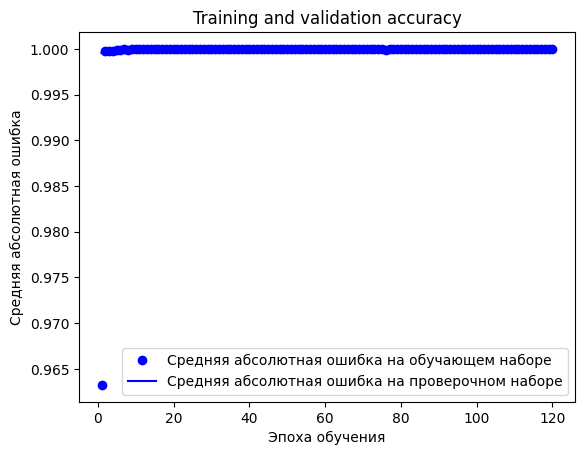

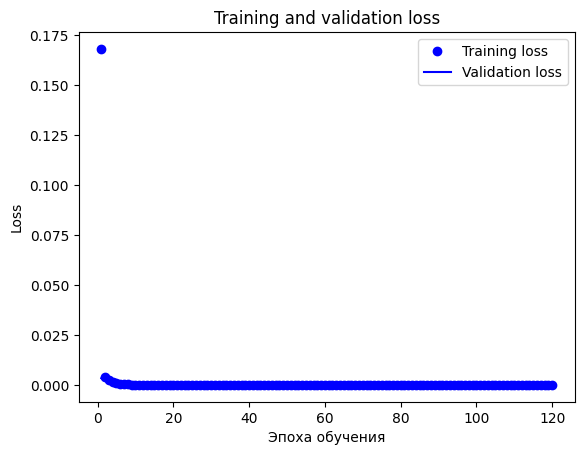

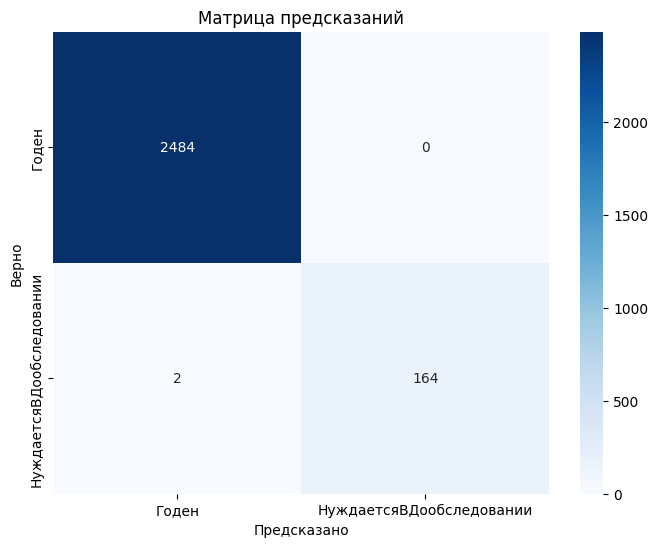

In [70]:
# Вывод результатов обучения с одним входным вектором
Print_Predict(model, x_test, y_test)
evaluate_model(model, x_test, y_test)

# Выводы
* Ввиду того что задача создаваемой НС носит характер "Рекомендательной системы"
по этому колонки "ЗаключениеМК" и колонок с "МКБ" для полноценного анализа не достаточно так как данные содержащиеся в этих колонках разбалансированны и мало информативны для рекомендации. "НС" тупо заучивает вместо анализа.

* В колонке "ЗаключениеМК" надо рассматривать два класса "Годен" (для однозначных решений), и класс  'НуждаетсяВДообследовании' когда есть наличие каких либо отклонений.  Так как для рекомендации необходимо понимание самой рекомендации необходимо реализовать отсыл к заключениям специалистов которые обнаружили отклонения, что также небходимо при условии "ограниченно годен", необходимо понимание причины. При фомировании архитектуры НС для эффективности обучения следует расматривать столбцы с уже приобретёнными болезнями и явными диагнозами такие как:
'Заключение', "ЖалобыДополнение" и тому подобных в виде отрицательных факторов 'диагноза', подавая их на отдельный вход вместе с колонками группы персона.

* Так мы устраняем разбалансировку и даём вектор поиска патологий, но метод не будет работать если рассматривать профессии разных групп риска в одном поле.

* Для более точной работы "НС" к примеру не желательно рассматривать музыканта в одном поле с шахтёром так как разные подходы к требованиям состояний здоровья. Так же будет ошибкой если отрицательный вывод для одной профессии по конкретному человеку запомнится системой и проявит себя отрицательно в ситуации для другой профессии на которую претендует этот человек где меньше требований к состоянию здоровья. Так для музыканта потеря руки не помешает стать композитором или учителем музыки а для юриста вообще из всех конечностей достаточно трёх пальцев. Для полноценного анлиза потребуется структуризация профессий с классификацией по группам  и кластеризацией по факторам риска ( описано выше во вкладке "Классификация условий труда").

* **В этой "НС" надо рассматривать два класса "Годен" (для однозначных решений)
 и класс 'НуждаетсяВДообследовании'который в свою очередь будет выдавать класс специализации врача который  определил патологию**.